In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

global test_A , test_B

class DrawSptTempMeanVel(object):
    '''Draw spatial-temperal mean velocity cell map'''
    
    def __init__(self, df, local_y = 'local_y', lane_id = 'lane_id' , time_diff = 't_diff', v_vel = 'v_vel'):
        '''The _colStr are the column name used'''
        # stroe the colname 
        df[local_y] = df[local_y].astype(float)
                                                        # df[local_y] = df[local_y] * 0.3048 # convert feet to meter
        df[v_vel] = df[v_vel].astype(float)
                                                        # df[v_vel] = df[v_vel] * 0.3048 *3.6 # convert feet/s to km/h
        df[v_vel] = df[v_vel] * 0.681818 # convert feet/s to mph
        df[time_diff] = df[time_diff].astype(int)
        
        self.df = df 
        
        self.local_y_colStr = local_y
        self.lane_id_colStr = lane_id
        self.time_diff_colStr = time_diff
        self.v_vel_colStr = v_vel
        
        # set the inital lane_id
        self.lane_id = list(set(df[lane_id].tolist()))[0]
        
        # init of the mapMap
        self.mapMat = np.zeros(1)
        self.temperalGrid = np.array([0,1])
        self.spatialGrid = np.array([0,1])
        
        
    def SetLaneId(self, lane_id):
        self.lane_id = lane_id
        return lane_id
    
    def GetSpatialTemperalMap_getSptTpGrid ( self, minLocalY, maxLocalY, minTdiff, maxTdiff, spatialLevel, temperalLevel ):
        '''
        get the list/array of the spa-temp grid
        --------------------------------------------
        sptialGrid: [0m, 10m, 20, ...]
        temperalGrid: [0s, 10s, 20s, ...]
        '''
        
        #sptialGrid = np.array( [x for x in range( minLocalY, maxLocalY, int((maxLocalY-minLocalY)/spatialLevel ))] )
        #temperalGrid = np.array( [x for x in range( minTdiff, maxTdiff, int((maxTdiff-minTdiff)/temperalLevel ))] )
        sptialGrid = np.arange( minLocalY, maxLocalY, (maxLocalY-minLocalY)/spatialLevel )
        temperalGrid = np.arange(minTdiff, maxTdiff, (maxTdiff-minTdiff)/temperalLevel )
        return sptialGrid, temperalGrid
    
    def GetSpatialTemperalMap_getMapMat( self, spatialGrid, temperalGrid ):
        '''
        get the map mat for the mean velocity
        ---------------------------------------------
        mapMat:         0-10s      10-20s     20-30s
                0-10m [ 0m/s       1m/s       2m/s ]
                10-20m[ 1m/s       2m/s       3m/s ]
                20-30m[ 2m/s       3m/s       2m/s ]
        '''
        # get the column name str
        local_y_colStr = self.local_y_colStr ; time_diff_colStr = self.time_diff_colStr; lane_id_colStr = self.lane_id_colStr
        v_vel_colStr = self.v_vel_colStr
        df = self.df
        lane_id = self.lane_id

        # matMap to store the mean velocity
        mapMat = np.zeros( (len(spatialGrid)-1, len(temperalGrid)-1) )

        
        # pick the dataframe in a lane
        df_inOneLane = df[df['lane_id'] == '2']

        # loop
        for timeIdx, timeStart in enumerate(temperalGrid[:-1]):
            for spaceIdx, spaceStart in enumerate(spatialGrid[:-1]):
                # the end point for space the time
                timeEnd = temperalGrid[timeIdx + 1]
                spaceEnd = spatialGrid[spaceIdx + 1]

                # the data in a cell
                mask_time = (df_inOneLane['t_diff'] >= timeStart) & (df_inOneLane['t_diff'] < timeEnd)
                mask_space = (df_inOneLane['local_y'] >= spaceStart) & (df_inOneLane['local_y'] < spaceEnd)
                df_inOneCell = df_inOneLane.loc[mask_time&mask_space, :]

                # calculate the speed
                meanVel = df_inOneCell['v_vel'].sum() / len( df_inOneCell['v_vel'] )

                # save it
                mapMat[spaceIdx, timeIdx] = meanVel
        return mapMat
    
    def GetSpatialTemperalMap(self, spatialLevel = 100, temperalLevel = 100):
        # get the grid information 
        minLocalY = min( self.df[self.local_y_colStr] ) ; maxLocalY = max( self.df[self.local_y_colStr] + 1.0 )
                                                          # +1 is because the ">= & <" is used in cell segmentation
                                                          # and the max shoud be included
        minTdiff = min( self.df[self.time_diff_colStr] ) ; maxTdiff = max( self.df[self.time_diff_colStr] + 1 )
        spatialGrid, temperalGrid = self.GetSpatialTemperalMap_getSptTpGrid( minLocalY, maxLocalY, minTdiff, maxTdiff,
                                                                      spatialLevel, temperalLevel )
        
        # print the grid info: (g[start], g[end],interval)
        print("temperalGrid: ({}, {}, {})".format(temperalGrid[0], temperalGrid[-1], temperalGrid[1] - temperalGrid[0]))
        print("sptialGrid: ({}, {}, {})".format(spatialGrid[0], spatialGrid[-1], spatialGrid[1] - spatialGrid[0]))
        
        # mapMat: store the mean velocity
        '''the original below'''
        mapMat = self.GetSpatialTemperalMap_getMapMat(spatialGrid, temperalGrid)
        self.mapMat = mapMat
        
        return mapMat
        '''the test'''
        #return spatialGrid, temperalGrid
    def heatmap(self, path = './', filename = 'v_map.png'):
        # copy data from the self
        mapMat = self.mapMat; temperalGrid = self.temperalGrid; spatialGrid = self.spatialGrid
        data = mapMat

        # create discrete colormap
        colors = [(1,0,0), (0,1,0)] # Red Green
        n_bins = 100 # Discretizes the interpolation into bins
        cmap_name = 'traffic_heat_list'
        cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

        fig, ax = plt.subplots(figsize = (20,20))
        im = ax.imshow(data, cmap=cmap, interpolation = 'nearest')

        # draw gridlines
        # ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-.5, 100,20))
        ax.set_xticklabels(np.arange(0*27, 100*27, 20*27), fontsize = 16);
        ax.set_xlabel('time/s',fontsize = 16)


        ax.set_yticks(np.arange(-.5, 50, 10));
        ax.set_yticklabels(np.arange(0*13, 50*13, 10*13), fontsize = 16);
        ax.set_ylabel('distance/m',fontsize = 16)

        ax.set_ylim(ax.get_ylim()[::-1])
        fig.colorbar(im, ax = ax)
        #plf.xlabel()

        #plt.show()
        plt.savefig(path + '/' + filename,dpi = 300)

        
        

/home/zm2302/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zm2302/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/zm2302/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in double_scalars


temperalGrid: (10.0, 2733.4900000000007, 27.510000000000005)
sptialGrid: (29.33, 2137.3903600000003, 43.021640000000005)


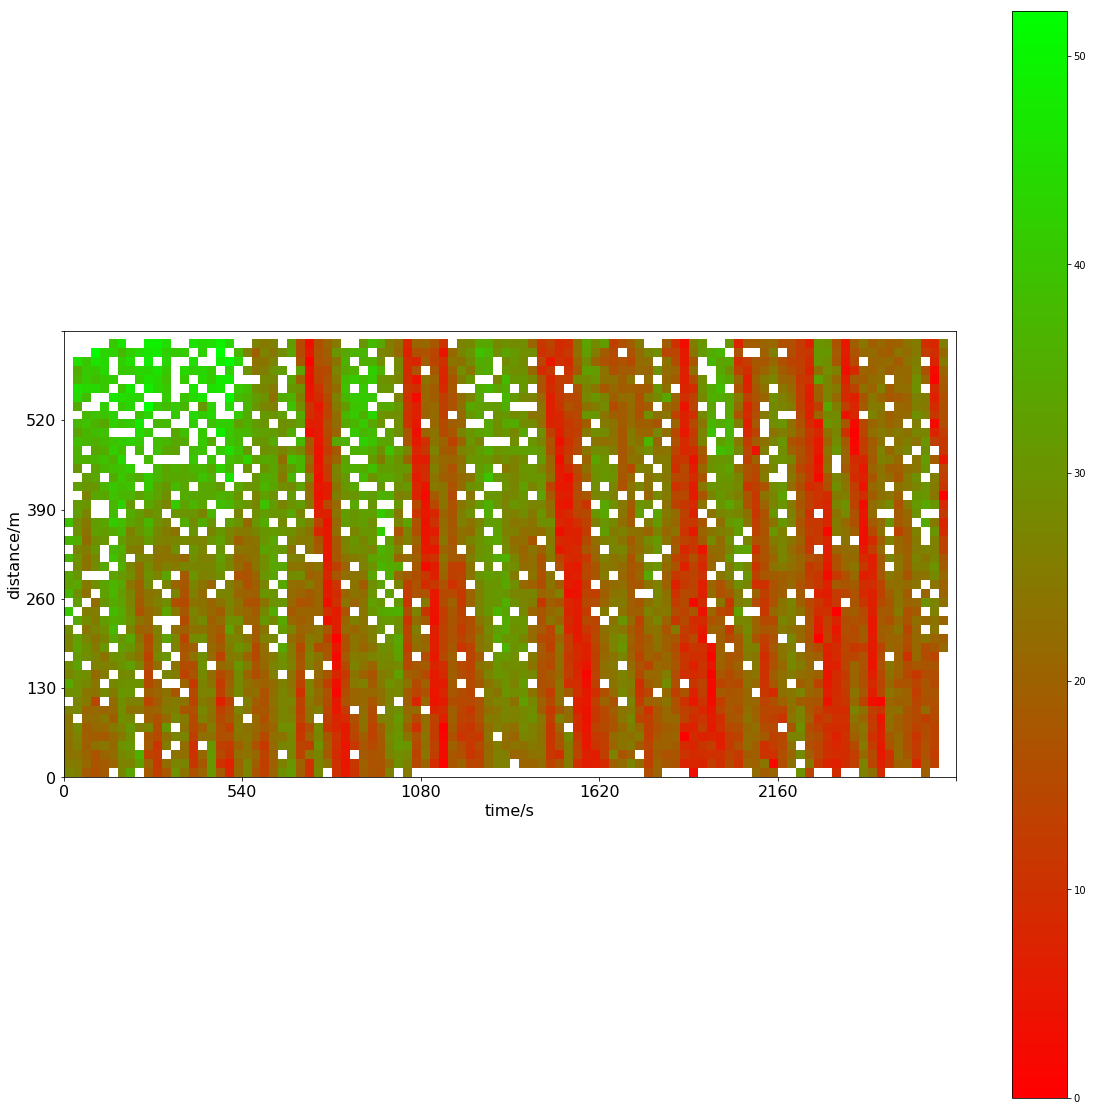

In [34]:
if __name__ == "__main__":
    from pyproj import Proj
    import pyproj
    import pandas as pd
    from sodapy import Socrata
    import matplotlib.pyplot as plt
    from matplotlib import colors
    import numpy as np

    # Unauthenticated client only works with public data sets. Note 'None'
    # in place of application token, and no username or password:
    client = Socrata("data.transportation.gov", None)

    # Example authenticated client (needed for non-public datasets):
    # client = Socrata(data.transportation.gov,
    #                  MyAppToken,
    #                  userame="user@example.com",
    #                  password="AFakePassword")

    # First 2000 results, returned as JSON from API / converted to Python list of
    # dictionaries by sodapy.
        #results = client.get("jqsx-yj2r", limit=2000)
    results = client.get("jqsx-yj2r", where = "global_time%1000 =0 and vehicle_id = 1", limit = 100000)
    # Convert to pandas DataFrame
    results_df = pd.DataFrame.from_records(results)

    #results_df = results_df.sort_values(['vehicle_id','frame_id'])

    '''
    Convert the cordanate
    out: dfSet
    '''
    # EPSG 4326(WGS84): the common lat/lon system
    # EPSG 2229: California State Plane Coordinate System, Zone 5, 
        #NAD83 http://spatialreference.org/ref/epsg/nad83-california-zone-5-ftus/ ( but use http://epsg.io/4326 here)
        #bOUND:5528230.8160, 1384701.5952, 7751890.9134, 2503239.6463 (epsg2229)
            #-121.3600, 32.7500, -114.1300, 35.8100(WGS84)


    wgs84 = Proj("+proj=longlat +datum=WGS84 +no_defs ") # there should not be " " between the "init" and the "EPSG
    epsg2229 = Proj("+proj=lcc +lat_1=35.46666666666667 +lat_2=34.03333333333333 +lat_0=33.5 +lon_0=-118 +x_0=2000000.0001016 +y_0=500000.0001016001 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=us-ft +no_defs", preserve_units=True) # Pyproj expects degrees (lon, lat) or meters (x,y) as units but the unit of Projection: 2263 isUNIT["US survey foot"...

    #print( pyproj.transform(epsg2229,wgs84, 6451128.359, 1873301.311) )

    class Converter:
        def __init__(self, df, colXin, colYin, colXout, colYout, projIn, projOut):
            self.df = df
            self.colXin = colXin
            self.colYin = colYin
            self.colXout = colXout
            self.colYout = colYout
            self.projIn = projIn
            self.projOut = projOut
        def convert(self, xy):  
            xIn = xy[0:xy.index(' ')]; yIn = xy[xy.index(' ')+1 : ]
            xOut, yOut = pyproj.transform(self.projIn, self.projOut, xIn, yIn)
            xy_out = str(xOut) + ' ' + str(yOut)
            return xy_out
        def returnX(self, xyStr):
            x = xyStr[ 0  :xyStr.index(' ')]
            return x
        def returnY(self, xyStr):
            y = xyStr[xyStr.index(' ') + 1 : ]
            return y
        def convertCordinate(self):
            col_x = self.colXin; col_y = self.colYin
            col_x_out = self.colXout; col_y_out = self.colYout
            df = self.df
            # assemble into one column for applying the 'apply'
            df[col_x] = df[col_x].astype(str); df[col_y] = df[col_y].astype(str)
            df['xy'] = df[col_x] + ' ' + df[col_y]
            # begin convert
            df['xy_out'] = df['xy'].apply(self.convert)
            # return the X and Y from the assemble OUT
            df[col_x_out] = df['xy_out'].apply(self.returnX)
            df[col_y_out] = df['xy_out'].apply(self.returnY)
            # delete the temp
            del(df['xy'], df['xy_out'])
            return df

    # test of the Class Converter
    CVTer = Converter(results_df, 'global_x', 'global_y', 'wgs_x', 'wgs_y', epsg2229, wgs84)
    dfSet = CVTer.convertCordinate()
    dfSet['wgs_x'] = dfSet['wgs_x'].astype(float);  dfSet['wgs_y'] = dfSet['wgs_y'].astype(float)
    dfSet.columns

    import datetime
    def epoch2datetime(epochTime):
        # Epoch in dataset is 10^13 (millsec)
        # however, it is 10^10 (sec) in the python package, so there should be a '.' before the last 3 digit 
        dateTime = datetime.datetime.fromtimestamp(float(str(epochTime)[:-3]+'.'+str(epochTime)[-3:])).strftime('%Y-%m-%d %H:%M:%S')
        return dateTime
    dfSet['data_time'] = dfSet['global_time'].apply(epoch2datetime)

    # get the date from the client
    '''dfSet: the date set for visulization
    '''
    location = "\"us-101\""
    results = client.get("jqsx-yj2r", where = "global_time % 10000 = 0 and location = {} ".format(location) , limit = 100000)
    results_df = pd.DataFrame.from_records(results)

    results_df = results_df.sort_values(['vehicle_id','lane_id','global_time'])
    if location == "\"peachtree\"":
        results_df['date_time'] = (results_df['global_time'] + '000').apply(epoch2datetime)
    else:
        results_df['date_time'] = results_df['global_time'].apply(epoch2datetime)
    dfSet = results_df[['vehicle_id', 'global_time', 'date_time', 'frame_id', 'local_y','v_vel','v_class','lane_id','total_frames', 'location']]
    dfSet['vehicle_id'] = dfSet['vehicle_id'].astype(int)
    dfSet['v_class'] = dfSet['v_class'].astype(int)
    dfSet = dfSet.sort_values(['vehicle_id', 'v_class', 'global_time'])
    
    theLaneId = '2'
    df = dfSet[dfSet['lane_id'] == theLaneId]
    df['global_time'] = df['global_time'].astype(int)
    df['t_diff'] = (df['global_time'] - 1118846979700)/1000; df['t_diff'] = df['t_diff'].astype(int)
    df = df.sort_values('global_time')
    VelMapper = DrawSptTempMeanVel(df)

    # set lane id
    laneId = VelMapper.SetLaneId(2)

    # compute and plot
    mapMat = VelMapper.GetSpatialTemperalMap(spatialLevel = 50, temperalLevel = 100)
    VelMapper.heatmap(filename='v_map_temp.png')